In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.ticker import FuncFormatter
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import Parallel, delayed
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
import plotly.graph_objects as go


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data quality check and insights

In [ ]:
# Load data
data = pd.read_csv('Half_Ironman_df6.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840075 entries, 0 to 840074
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Gender           840075 non-null  object
 1   AgeGroup         840075 non-null  object
 2   AgeBand          840075 non-null  int64 
 3   Country          840075 non-null  object
 4   CountryISO2      840075 non-null  object
 5   EventYear        840075 non-null  int64 
 6   EventLocation    840075 non-null  object
 7   SwimTime         840075 non-null  int64 
 8   Transition1Time  840075 non-null  int64 
 9   BikeTime         840075 non-null  int64 
 10  Transition2Time  840075 non-null  int64 
 11  RunTime          840075 non-null  int64 
 12  FinishTime       840075 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 83.3+ MB


In [ ]:
data.describe(include='all')

,Gender,AgeGroup,AgeBand,Country,CountryISO2,EventYear,EventLocation,SwimTime,Transition1Time,BikeTime,Transition2Time,RunTime,FinishTime
count,840075,840075,840075.000000,840075,840075,840075.000000,840075,840075.000000,840075.000000,840075.000000,840075.000000,840075.000000,840075.000000
unique,2,15,NaN,240,240,NaN,195,NaN,NaN,NaN,NaN,NaN,NaN
top,M,35-39,NaN,United States,US,NaN,IRONMAN 70.3 World Championship,NaN,NaN,NaN,NaN,NaN,NaN
freq,635680,160918,NaN,332037,332037,NaN,26123,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,36.904936,NaN,NaN,2015.113096,NaN,2340.250398,286.679245,10675.310285,219.786933,7606.965184,21129.008952
std,NaN,NaN,10.837156,NaN,NaN,3.176755,NaN,486.450902,98.416839,1397.954592,94.242916,1588.104360,3076.234712
min,NaN,NaN,0.000000,NaN,NaN,2004.000000,NaN,1201.000000,46.000000,6511.000000,46.000000,4002.000000,13004.000000
25%,NaN,NaN,30.000000,NaN,NaN,2013.000000,NaN,2010.000000,211.000000,9682.000000,147.000000,6440.000000,18919.000000
50%,NaN,NaN,35.000000,NaN,NaN,2016.000000,NaN,2286.000000,280.000000,10503.000000,205.000000,7362.000000,20839.000000
75%,NaN,NaN,45.000000,NaN,NaN,2018.000000,NaN,2604.000000,359.000000,11483.000000,279.000000,8544.000000,23052.000000


In [ ]:
data['Gender'].value_counts()

Gender
M    635680
F    204395
Name: count, dtype: int64

In [ ]:
data.isna().sum()

Gender             0
AgeGroup           0
AgeBand            0
Country            0
CountryISO2        0
EventYear          0
EventLocation      0
SwimTime           0
Transition1Time    0
BikeTime           0
Transition2Time    0
RunTime            0
FinishTime         0
dtype: int64

In [ ]:
df = data.dropna()

In [ ]:

df = df.query('2010 <= EventYear <= 2020')


In [ ]:
# Charts inline
%matplotlib inline


# Define graphics style
plt.style.use('seaborn-whitegrid')

# Set precision to two decimals
pd.set_option("display.precision", 2)

# Male and female colors
mcol = 'royalblue'
fcol = 'orchid'

<ipython-input-11-a63814dee7b9>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
# Function to convert time in seconds to HH:MM:SS
def time_in_HHMMSS(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f'{hours:02}:{minutes:02}:{secs:02}'

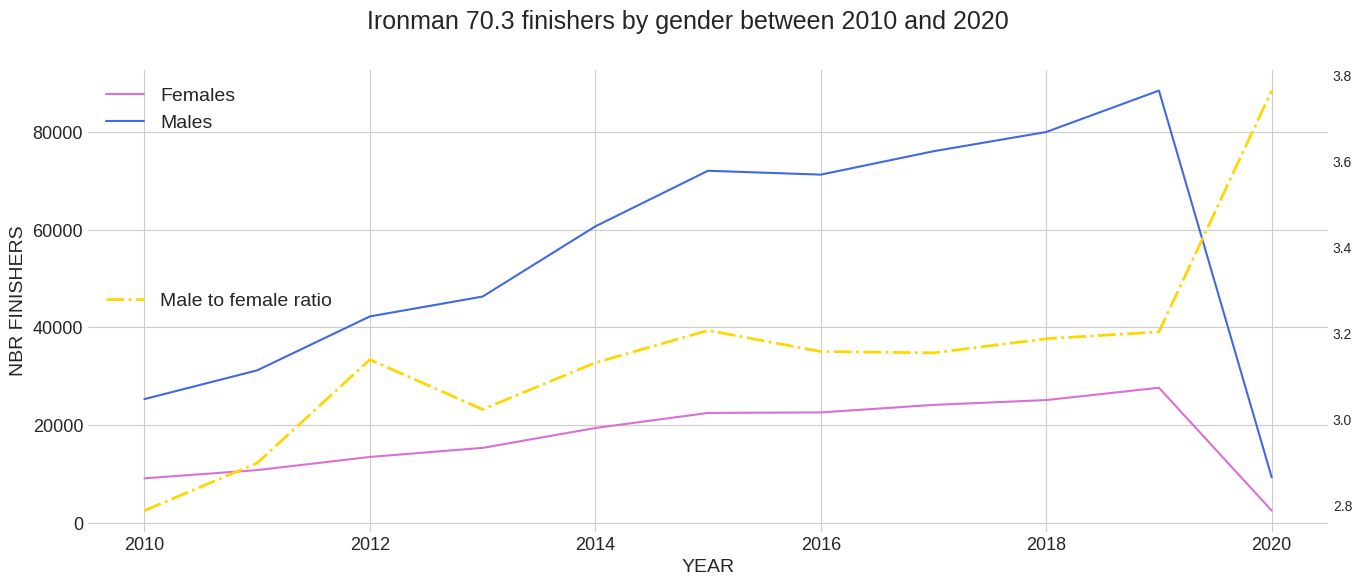

In [ ]:
# Evolution of the number of finishers by gender
female_finishers_by_year = df[df['Gender']=='F'].groupby(by=['EventYear']).count()
male_finishers_by_year = df[df['Gender']=='M'].groupby(by=['EventYear']).count()

f, ax = plt.subplots(1,1, figsize=(16,6))
f.suptitle("Ironman 70.3 finishers by gender between 2010 and 2020", fontsize=18)

ax.plot(female_finishers_by_year.index, female_finishers_by_year['Gender'],
        label='Females', lw=1.5, color=fcol)
ax.plot(male_finishers_by_year.index, male_finishers_by_year['Gender'],
        label='Males', lw=1.5, color=mcol)

ax.set_xlabel('YEAR', fontsize='14')
ax.set_ylabel('NBR FINISHERS', fontsize='14')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='upper left', fontsize='14')
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax2 = ax.twinx()
ax2.plot(male_finishers_by_year.index, male_finishers_by_year['Gender']/female_finishers_by_year['Gender'],
         label='Male to female ratio', lw=2, color='gold', linestyle='-.')
ax2.legend(loc='center left', fontsize=14)
ax2.spines["left"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.grid(visible=False)
plt.show()

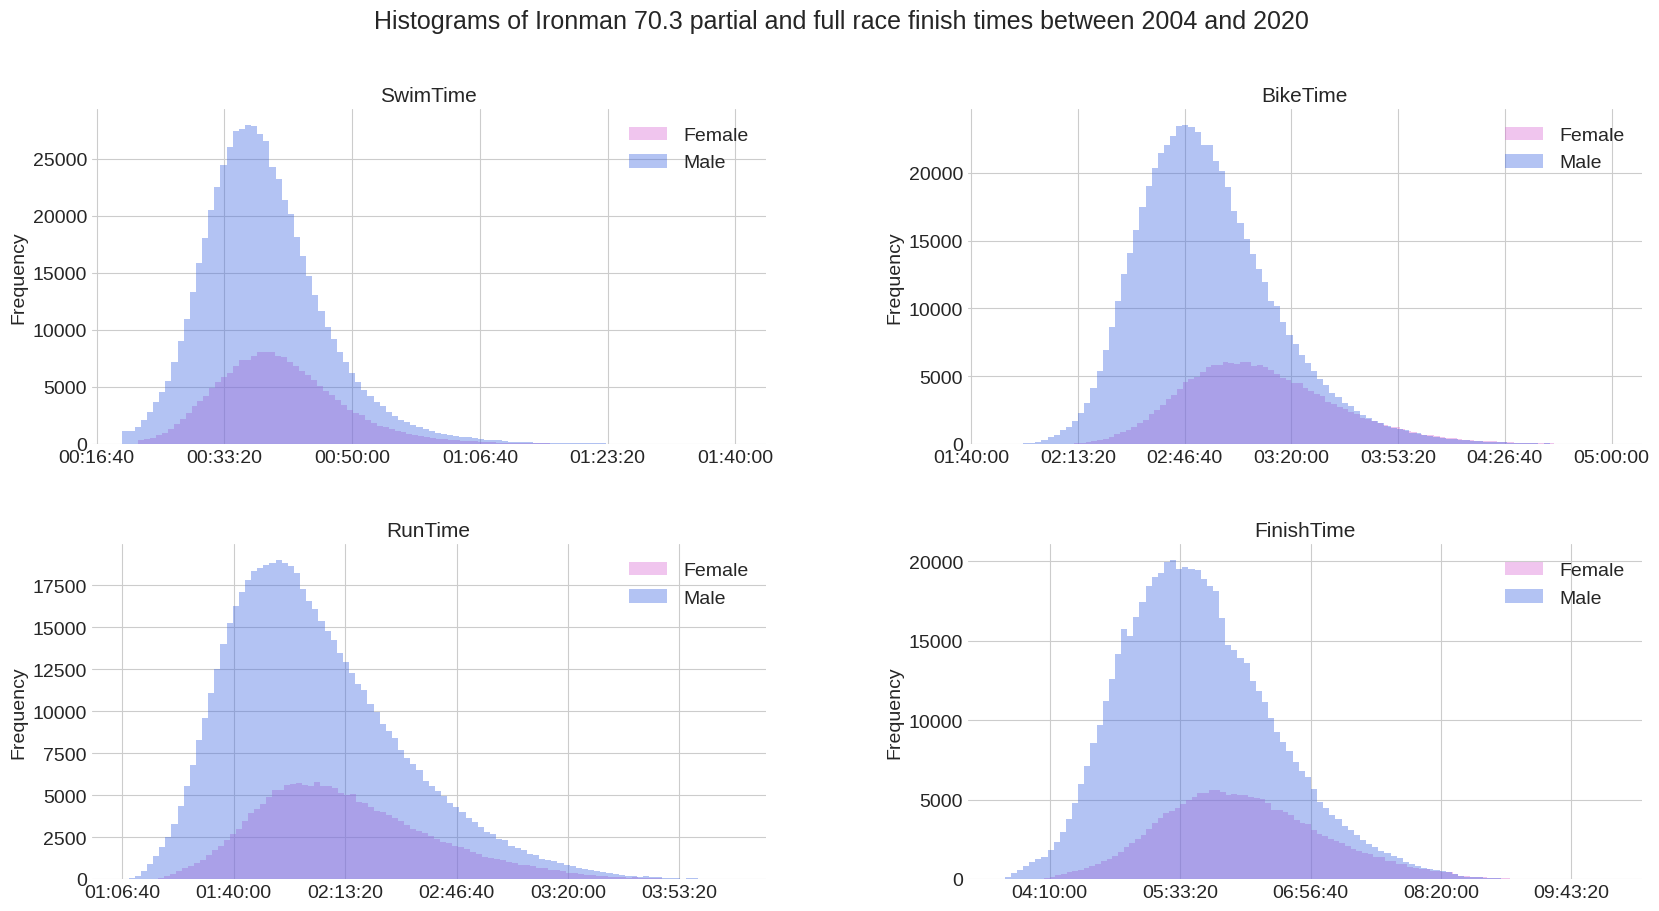

In [ ]:
# List of time columns
timeColumns = ['SwimTime', 'BikeTime', 'RunTime', 'FinishTime']


# Make sur the time columns are numerical
for col in timeColumns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert time columns in HH:MM:SS format
for col in timeColumns:
    df[col + '_HHMMSS'] = df[col].apply(time_in_HHMMSS)

# Code for the plot


fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plt.suptitle("Histograms of Ironman 70.3 partial and full race finish times between 2004 and 2020", fontsize=18)

i, j = 0, 0
for x in timeColumns:
    # Histograms for each gender
    df[df['Gender'] == 'F'].hist(column=x, bins=100, label='Female', color=fcol, alpha=0.4, ax=ax[i, j])
    df[df['Gender'] == 'M'].hist(column=x, bins=100, label='Male', color=mcol, alpha=0.4, ax=ax[i, j])

    ax[i, j].set_title(x, fontsize=15)
    ax[i, j].set_ylabel('Frequency', fontsize=14)
    ax[i, j].tick_params(axis='both', which='major', labelsize=14)

    # Format xtick labels in HH:MM:SS
    formatter = FuncFormatter(lambda s, _: time_in_HHMMSS(int(s)))
    ax[i, j].xaxis.set_major_formatter(formatter)

    ax[i, j].legend(loc='upper right', fontsize=14)

    # Hide corners of the plot
    ax[i, j].spines["left"].set_visible(False)
    ax[i, j].spines["right"].set_visible(False)
    ax[i, j].spines["top"].set_visible(False)
    ax[i, j].spines["bottom"].set_visible(False)

    if j < 1:
        j += 1
    else:
        j = 0
        i += 1

plt.show()

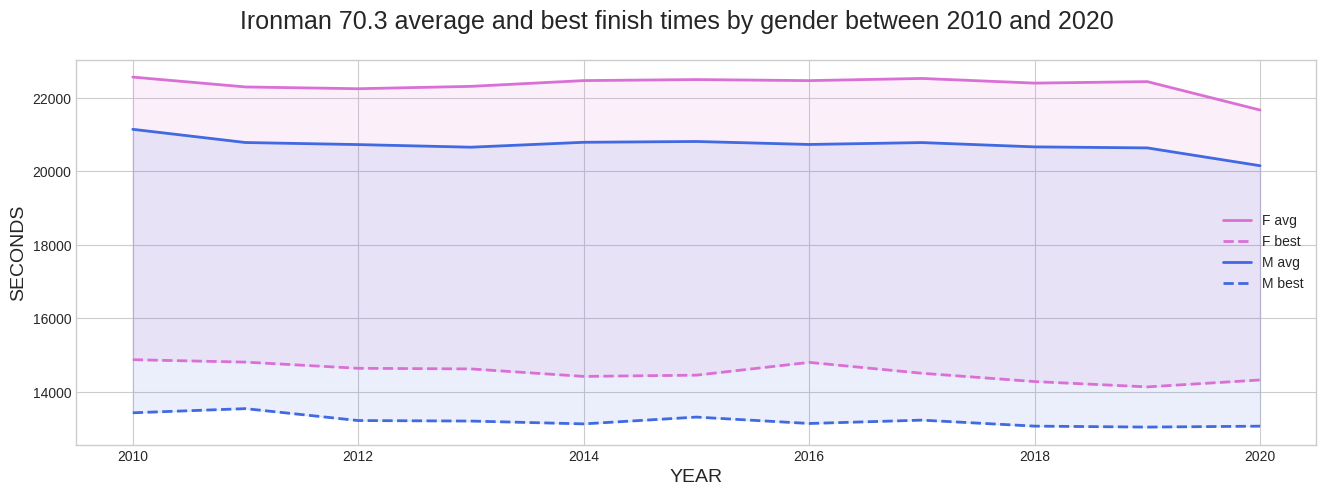

In [ ]:

# Calculate male and female average and best (min) finish time
female_average_time_by_year = df[df['Gender']=='F'][['EventYear', 'FinishTime']].groupby(by=['EventYear']).mean()
female_best_time_by_year = df[df['Gender']=='F'][['EventYear', 'FinishTime']].groupby(by=['EventYear']).min()
male_average_time_by_year = df[df['Gender']=='M'][['EventYear', 'FinishTime']].groupby(by=['EventYear']).mean()
male_best_time_by_year = df[df['Gender']=='M'][['EventYear', 'FinishTime']].groupby(by=['EventYear']).min()

# Code for the plot and the axes
f, ax = plt.subplots(1, 1, figsize=(16, 5))
f.suptitle("Ironman 70.3 average and best finish times by gender between 2010 and 2020", fontsize=18)

# Lines for women
ax.plot(female_average_time_by_year.index, female_average_time_by_year['FinishTime'],
        label='F avg', lw=2, color=fcol)
ax.plot(female_best_time_by_year.index, female_best_time_by_year['FinishTime'],
        label='F best', lw=2, color=fcol, linestyle='--')
ax.fill_between(female_average_time_by_year.index, female_best_time_by_year['FinishTime'], female_average_time_by_year['FinishTime'],
               color=fcol, alpha=0.1)

# Lines for men
ax.plot(male_average_time_by_year.index, male_average_time_by_year['FinishTime'],
        label='M avg', lw=2, color=mcol)
ax.plot(male_best_time_by_year.index, male_best_time_by_year['FinishTime'],
        label='M best', lw=2, color=mcol, linestyle='--')
ax.fill_between(male_average_time_by_year.index, male_best_time_by_year['FinishTime'], male_average_time_by_year['FinishTime'],
               color=mcol, alpha=0.1)

# Labels
ax.set_xlabel('YEAR', fontsize=14)
ax.set_ylabel('SECONDS', fontsize=14)

# Legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Male stats
df_m_HMS = df[df['Gender']=='M'][['SwimTime', 'BikeTime', 'RunTime', 'FinishTime']].aggregate(['mean', 'std', 'min', 'max'])

for x in timeColumns:
  df_m_HMS[x] = df_m_HMS[x].apply(time_in_HHMMSS)

df_m_HMS.columns = pd.MultiIndex.from_product([["Male stats"], df_m_HMS.columns])

# Female stats
df_f_HMS = df[df['Gender']=='F'][['SwimTime', 'BikeTime', 'RunTime', 'FinishTime']].aggregate(['mean', 'std', 'min', 'max'])

for x in timeColumns:
  df_f_HMS[x] = df_f_HMS[x].apply(time_in_HHMMSS)

df_f_HMS.columns = pd.MultiIndex.from_product([["Female stats"], df_f_HMS.columns])



df_mf_HMS = pd.concat([df_m_HMS, df_f_HMS], axis=1)
df_mf_HMS

Male stats                               \
                         SwimTime                     BikeTime   
mean  0.0:38.0:31.881143383742256  2.0:53.0:59.248533145930196   
std     0.0:7.0:59.36374078664494   0.0:21.0:42.05654775268954   
min                  0.0:20.0:1.0                1.0:48.0:31.0   
max                 1.0:39.0:57.0                4.0:59.0:53.0   

                                                               \
                          RunTime                  FinishTime   
mean   2.0:4.0:34.882577088567814  5.0:45.0:31.47535850908025   
std   0.0:26.0:12.189963803612955  0.0:49.0:20.38356477650541   
min                  1.0:6.0:42.0               3.0:37.0:15.0   
max                  4.0:9.0:59.0               10.0:8.0:49.0   

                    Female stats                               \
                        SwimTime                     BikeTime   
mean  0.0:40.0:35.57819779671854   3.0:10.0:33.78531249513071   
std   0.0:8.0:17.752818671600437  0.0:23.0:47.159118131446576   
min                 0.0:22.0:1.0                 2.0:1.0:30.0   
max                1.0:39.0:56.0                4.0:59.0:47.0   

                                                               
                         RunTime                   FinishTime  
mean  2.0:13.0:48.23312090001127   6.0:13.0:38.88500553157792  
std   0.0:26.0:7.055444190857315  0.0:51.0:24.923590534295727  
min                1.0:10.0:15.0                3.0:55.0:29.0  
max                 4.0:9.0:43.0                9.0:58.0:19.0

<ipython-input-17-33a76c5d082a>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(l0, fontsize=13)


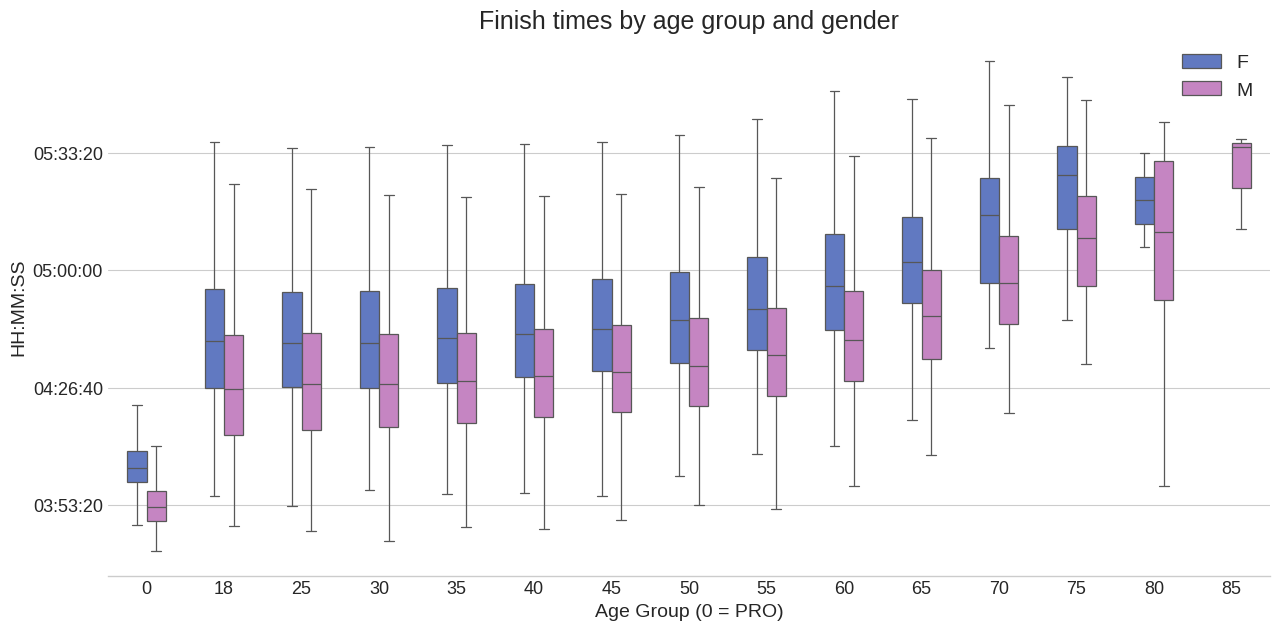

In [ ]:
# Get x-axis ticks in seconds and convert to HH:MM:SS
l0 = []
for t in ax.get_yticklabels():
  l0.append(time_in_HHMMSS(int(t.get_text())))

# Distribution of overall finish times (in HH:MM:SS) by age group and gender
fig, ax = plt.subplots(figsize=(15,7))

ax.set_title("Finish times by age group and gender", fontsize=18);
sns.boxplot(x = "AgeBand", y = "FinishTime", hue='Gender', data=df, saturation=0.6, palette=[mcol, fcol],
            width=0.5, linewidth=0.9, showfliers=False, ax=ax)
ax.set_xlabel('Age Group (0 = PRO)', fontsize=14)
ax.set_ylabel('HH:MM:SS', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_yticklabels(l0, fontsize=13)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(fontsize=14)
plt.show()

In [ ]:
# Perform two-way ANOVA
model = ols('FinishTime ~ C(AgeBand) + C(Gender) + C(AgeBand):C(Gender)', data=df).fit()
sm.stats.anova_lm(model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,1.64e+12,1.0,202816.50,0.00e+00
C(AgeBand),2.43e+11,14.0,2146.57,0.00e+00
C(Gender),9.42e+09,1.0,1164.87,4.02e-255
C(AgeBand):C(Gender),1.84e+09,14.0,16.22,1.58e-40
Residual,6.44e+12,795834.0,NaN,NaN


In [ ]:
#The results of the ANOVA two-way test show that, for each independent variable (age group and gender) and
#their combined effect, the calculated p-pvalues PR(>F) are zero or nearly zero, and hence we can conclude that
#the differences between age groups and genders are statistically significant.

Machine Learning (regression) : predict IRONMAN 70.3 finnish time with : Age, Sex, and Half-marathon time with marathon pace.

In [ ]:


# Feature and target selection
X = df[['RunTime', 'AgeBand', 'Gender']]
y = df['FinishTime']


# Drop lines with missing values
X = X.dropna()
y = y[X.index]

# Gender encoding
X['Gender'] = X['Gender'].map({'M': 0, 'F': 1})

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['RunTime', 'AgeBand']),
        ('cat', OneHotEncoder(), ['Gender'])
    ])



In [ ]:
# Models to use
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42),  # Nombre d'estimations réduit
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, random_state=42),  # Nombre d'estimations réduit
    'XGBoost': XGBRegressor(n_estimators=50, random_state=42)  # Nombre d'estimations réduit
}

# Function to evaluate the models
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    # Cross validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = (-cv_scores)**0.5
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return {
        'Model Name': model_name,
        'CV RMSE': rmse_scores.mean(),
        'CV RMSE Std': rmse_scores.std(),
        'Test MAE': mae,
        'Test RMSE': rmse,
        'Pipeline': pipeline
    }




In [ ]:
# Evaluation of each model
results = Parallel(n_jobs=-1)(
    delayed(evaluate_model)(name, model, X_train, y_train, X_test, y_test)
    for name, model in models.items()
)

# Print results
for result in results:
    print(f"Model: {result['Model Name']}")
    print(f"Validation RMSE: {result['CV RMSE']:.2f} ± {result['CV RMSE Std']:.2f}")
    print(f"Test MAE: {result['Test MAE']:.2f}")
    print(f"Test RMSE: {result['Test RMSE']:.2f}")
    print()

Model: Linear Regression
Validation RMSE: 1288.08 ± 2.46
Test MAE: 1001.95
Test RMSE: 1293.83

Model: Ridge Regression
Validation RMSE: 1288.08 ± 2.46
Test MAE: 1001.95
Test RMSE: 1293.83

Model: Lasso Regression
Validation RMSE: 1288.08 ± 2.46
Test MAE: 1001.95
Test RMSE: 1293.83

Model: Random Forest
Validation RMSE: 1383.32 ± 1.58
Test MAE: 1050.20
Test RMSE: 1364.94

Model: Gradient Boosting
Validation RMSE: 1261.01 ± 1.62
Test MAE: 978.84
Test RMSE: 1267.08

Model: XGBoost
Validation RMSE: 1259.10 ± 1.79
Test MAE: 976.72
Test RMSE: 1265.22



In [ ]:

# Print the best model
best_model = min(results, key=lambda x: x['Test RMSE'])

# Save model
joblib.dump(best_model, '/content/drive/MyDrive/Models/ironman_model.pkl')
print(f"Best Model: {best_model['Model Name']}")

Best Model: XGBoost


In [ ]:
# Function to convert pace (min/km) to time in seconds and HH:MM:SS
def convert_pace_to_total_time(pace_min_per_km):
    """
    Convertit une allure (min/km) en temps total pour un semi-marathon (21,1 km)

    Args:
    pace_min_per_km (float): Allure en minutes par kilomètre

    Returns:
    tuple: Temps total en secondes et formaté en HH:MM:SS
    """
    # Distance on half-marathon
    half_marathon_distance = 21.1

    # Time for a halh-marathon with the marathon pace
    total_time_minutes = pace_min_per_km * half_marathon_distance

    # Convert total time in seconds
    total_time_seconds = total_time_minutes * 60

    # Convert seconds to HH:MM:SS
    hours = int(total_time_seconds // 3600)
    minutes = int((total_time_seconds % 3600) // 60)
    seconds = int(total_time_seconds % 60)

    # Format HH:MM:SS
    total_time_hhmmss = f"{hours:02d}:{minutes:02d}:{seconds:02d}"

    return total_time_seconds, total_time_hhmmss

# Example with an average pace of 5.09 min/km at a marathon
pace_min_per_km = 5.09
total_seconds, total_hhmmss = convert_pace_to_total_time(pace_min_per_km)
print(f"Total time in secondes: {total_seconds}")
print(f"Total time in HH:MM:SS: {total_hhmmss}")

Total time in secondes: 6443.9400000000005
Total time in HH:MM:SS: 01:47:23


In [ ]:
# Prediction with the best model
RunTime = total_seconds  # Example : time
AgeBand = 27  #Example : Age
Gender = 0  # Exemple : 0 for Men, 1 for Women
data_input = pd.DataFrame([[RunTime, AgeBand, Gender]], columns=['RunTime', 'AgeBand', 'Gender'])

In [ ]:
predicted_time = best_model['Pipeline'].predict(data_input) #the time is in seconds
print(f'Your predicted time is : {(time_in_HHMMSS(int(predicted_time[0])))}') #time in HH:MM:SS


Your predicted time is : 05:18:01


Webscraping IRONMAN 70.3 host countries from https://www.ironman.com/im703-races

In [ ]:

# Send a GET request to the URL
url = "https://www.ironman.com/im703-races"
response = requests.get(url)



html_content ='''
<ul class="regionOptions"><ul key="0" data-value="Africa" class="africa"><li key="africa" data-value="Africa" class="continentTitle">Africa</li><li key="0" data-value="Egypt">Egypt</li><li key="1" data-value="Morocco">Morocco</li><li key="2" data-value="Rwanda">Rwanda</li><li key="3" data-value="South Africa">South Africa</li></ul><ul key="1" data-value="Asia" class="asia"><li key="asia" data-value="Asia" class="continentTitle">Asia</li><li key="0" data-value="Bahrain">Bahrain</li><li key="1" data-value="Dubai">Dubai</li><li key="2" data-value="India">India</li><li key="3" data-value="Israel">Israel</li><li key="4" data-value="Japan">Japan</li><li key="5" data-value="Kazakhstan">Kazakhstan</li><li key="6" data-value="Korea">Korea</li><li key="7" data-value="Malaysia">Malaysia</li><li key="8" data-value="Oman">Oman</li><li key="9" data-value="Philippines">Philippines</li><li key="10" data-value="Taiwan">Taiwan</li><li key="11" data-value="Thailand">Thailand</li><li key="12" data-value="Viet Nam">Viet Nam</li></ul><ul key="2" data-value="Europe" class="europe"><li key="europe" data-value="Europe" class="continentTitle">Europe</li><li key="0" data-value="Austria">Austria</li><li key="1" data-value="Belgium">Belgium</li><li key="2" data-value="Croatia">Croatia</li><li key="3" data-value="Czech Republic">Czech Republic</li><li key="4" data-value="Denmark">Denmark</li><li key="5" data-value="Estonia">Estonia</li><li key="6" data-value="Finland">Finland</li><li key="7" data-value="France">France</li><li key="8" data-value="Germany">Germany</li><li key="9" data-value="Greece">Greece</li><li key="10" data-value="Ireland">Ireland</li><li key="11" data-value="Italy">Italy</li><li key="12" data-value="Luxembourg">Luxembourg</li><li key="13" data-value="Netherlands">Netherlands</li><li key="14" data-value="Poland">Poland</li><li key="15" data-value="Portugal">Portugal</li><li key="16" data-value="Serbia">Serbia</li><li key="17" data-value="Spain">Spain</li><li key="18" data-value="Sweden">Sweden</li><li key="19" data-value="Switzerland">Switzerland</li><li key="20" data-value="Türkiye">Türkiye</li><li key="21" data-value="United Kingdom">United Kingdom</li></ul><ul key="3" data-value="North America" class="northamerica"><li key="north america" data-value="North America" class="continentTitle">North America</li><li key="0" data-value="Canada">Canada</li><li key="1" data-value="Mexico">Mexico</li><li key="2" data-value="Panama">Panama</li><li key="3" data-value="Puerto Rico">Puerto Rico</li><li key="4" data-value="United States">United States</li></ul><ul key="4" data-value="Oceania" class="oceania"><li key="oceania" data-value="Oceania" class="continentTitle">Oceania</li><li key="0" data-value="Australia">Australia</li><li key="1" data-value="New Zealand">New Zealand</li></ul><ul key="5" data-value="South America" class="southamerica"><li key="south america" data-value="South America" class="continentTitle">South America</li><li key="0" data-value="Argentina">Argentina</li><li key="1" data-value="Brazil">Brazil</li><li key="2" data-value="Chile">Chile</li><li key="3" data-value="Colombia">Colombia</li><li key="4" data-value="Dominican Republic">Dominican Republic</li><li key="5" data-value="Ecuador">Ecuador</li><li key="6" data-value="Perú">Perú</li><li key="7" data-value="Uruguay">Uruguay</li></ul></ul>
'''



# Parse the HTML
soup = BeautifulSoup(html_content, 'html.parser')

# Find all <ul> elements with class "regionOptions"
region_options = soup.find_all('ul', class_='regionOptions')

# Extract country names
country_names = []
for region in region_options:
    countries = region.find_all('li', class_=lambda x: x != 'continentTitle')
    for country in countries:
        if country.get('data-value'):
            country_names.append(country.get('data-value'))

print(country_names)



['Egypt', 'Morocco', 'Rwanda', 'South Africa', 'Bahrain', 'Dubai', 'India', 'Israel', 'Japan', 'Kazakhstan', 'Korea', 'Malaysia', 'Oman', 'Philippines', 'Taiwan', 'Thailand', 'Viet Nam', 'Austria', 'Belgium', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Poland', 'Portugal', 'Serbia', 'Spain', 'Sweden', 'Switzerland', 'Türkiye', 'United Kingdom', 'Canada', 'Mexico', 'Panama', 'Puerto Rico', 'United States', 'Australia', 'New Zealand', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Dominican Republic', 'Ecuador', 'Perú', 'Uruguay']


In [ ]:
# Replace occurence of 'United States' with 'United States of America' using a loop
for i in range(len(country_names)):
    if country_names[i] == 'United States':
        country_names[i] = 'United States of America'


# Now countries_list contains 'United States of America' instead of 'United States'
print(country_names)

['Egypt', 'Morocco', 'Rwanda', 'South Africa', 'Bahrain', 'Dubai', 'India', 'Israel', 'Japan', 'Kazakhstan', 'Korea', 'Malaysia', 'Oman', 'Philippines', 'Taiwan', 'Thailand', 'Viet Nam', 'Austria', 'Belgium', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Poland', 'Portugal', 'Serbia', 'Spain', 'Sweden', 'Switzerland', 'Türkiye', 'United Kingdom', 'Canada', 'Mexico', 'Panama', 'Puerto Rico', 'United States of America', 'Australia', 'New Zealand', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Dominican Republic', 'Ecuador', 'Perú', 'Uruguay']


<ipython-input-44-12a476722871>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


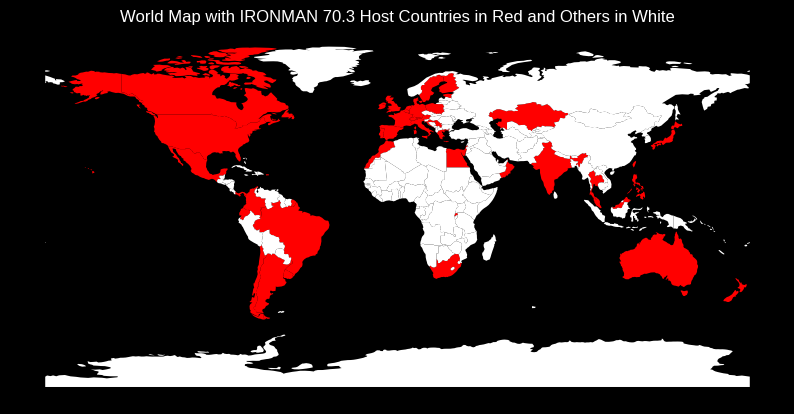

In [ ]:

# Load country data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a mask for countries in the list
mask = world['name'].isin(country_names)

# Create the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Change the background color of the figure to black
fig.patch.set_facecolor('black')

# Display the world map with a black background
world.plot(ax=ax, color='black', edgecolor='black')

# Color the countries in the list in red
world[mask].plot(ax=ax, color='red')

# Color the countries not in the list in white
world[~mask].plot(ax=ax, color='white')

# Turn off the axis
ax.axis('off')

# Show the map
plt.title('World Map with IRONMAN 70.3 Host Countries in Red and Others in White', color ="white")
plt.show()


In [ ]:

# Load country data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Print unique country names in the dataset
print(world['name'].unique())


<ipython-input-146-48017708f522>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


['Fiji' 'Tanzania' 'W. Sahara' 'Canada' 'United States of America'
 'Kazakhstan' 'Uzbekistan' 'Papua New Guinea' 'Indonesia' 'Argentina'
 'Chile' 'Dem. Rep. Congo' 'Somalia' 'Kenya' 'Sudan' 'Chad' 'Haiti'
 'Dominican Rep.' 'Russia' 'Bahamas' 'Falkland Is.' 'Norway' 'Greenland'
 'Fr. S. Antarctic Lands' 'Timor-Leste' 'South Africa' 'Lesotho' 'Mexico'
 'Uruguay' 'Brazil' 'Bolivia' 'Peru' 'Colombia' 'Panama' 'Costa Rica'
 'Nicaragua' 'Honduras' 'El Salvador' 'Guatemala' 'Belize' 'Venezuela'
 'Guyana' 'Suriname' 'France' 'Ecuador' 'Puerto Rico' 'Jamaica' 'Cuba'
 'Zimbabwe' 'Botswana' 'Namibia' 'Senegal' 'Mali' 'Mauritania' 'Benin'
 'Niger' 'Nigeria' 'Cameroon' 'Togo' 'Ghana' "Côte d'Ivoire" 'Guinea'
 'Guinea-Bissau' 'Liberia' 'Sierra Leone' 'Burkina Faso'
 'Central African Rep.' 'Congo' 'Gabon' 'Eq. Guinea' 'Zambia' 'Malawi'
 'Mozambique' 'eSwatini' 'Angola' 'Burundi' 'Israel' 'Lebanon'
 'Madagascar' 'Palestine' 'Gambia' 'Tunisia' 'Algeria' 'Jordan'
 'United Arab Emirates' 'Qatar' 'Kuwait'

In [3]:


# List of countries to color in red
red_countries = ['Egypt', 'Morocco', 'Rwanda', 'South Africa', 'Bahrain', 'Dubai', 'India', 'Israel', 'Japan', 'Kazakhstan', 'Korea', 'Malaysia', 'Oman', 'Philippines',
                 'Taiwan', 'Thailand', 'Viet Nam', 'Austria', 'Belgium', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Ireland',
                 'Italy', 'Luxembourg', 'Netherlands', 'Poland', 'Portugal', 'Serbia', 'Spain', 'Sweden', 'Switzerland', 'Türkiye', 'United Kingdom', 'Canada', 'Mexico', 'Panama',
                 'Puerto Rico', 'United States of America', 'Australia', 'New Zealand', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Dominican Republic', 'Ecuador', 'Perú',
                 'Uruguay']

    # ISO-3166-1 alpha-3 codes of the countries
iso_codes = ['EGY', 'MAR', 'RWA', 'ZAF', 'BHR', 'ARE', 'IND', 'ISR', 'JPN', 'KAZ', 'KOR', 'MYS', 'OMN', 'PHL',
             'TWN', 'THA', 'VNM', 'AUT', 'BEL', 'HRV', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'IRL',
             'ITA', 'LUX', 'NLD', 'POL', 'PRT', 'SRB', 'ESP', 'SWE', 'CHE', 'TUR', 'GBR', 'CAN', 'MEX', 'PAN',
             'PRI', 'USA', 'AUS', 'NZL', 'ARG', 'BRA', 'CHL', 'COL', 'DOM', 'ECU', 'PER', 'URY']

    # Create the map
fig = go.Figure()

    # Add a layer to the map
fig.add_trace(go.Choropleth(
    locations=iso_codes,  # ISO-3166-1 alpha-3 codes
    z=[1]*len(iso_codes),  # Values for color
    colorscale=[[0, 'grey'], [1, 'red']],  # Color scale
    showscale=False,  # Hide color scale
    geo='geo',
))

    # Map parameters
fig.update_geos(
    showcountries=True,  # Show borders between countries
    countrycolor='black', # Borders color
    oceancolor='black', # Oceans color
    projection_type='natural earth',  # Use default projection
    showocean=True,  # Be sure that oceans are shown
    lakecolor='black',# Lakes color
    bgcolor='black',
)

    # Ad Mapbox layaout
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        coastlinecolor='black',
        showland=True,
        landcolor='white',
        showocean=True,
        oceancolor='black'
    ),
    mapbox_style="carto-positron",  #  Mapbox style
    mapbox_zoom=1,  # Initial zoom level
    mapbox_center={"lat": 0, "lon": 0},  # Center of the map
)

# Show the map
fig.show(use_container_width=True)

In [4]:
fig.write_json("halfironman_map.json")